In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import waterfall_chart
import random
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.svm import SVR
from sklearn.metrics import accuracy_score, mean_squared_error
from collections import defaultdict
import ruptures as rpt

pd.options.mode.chained_assignment = None

### Analiza danych i przygotowanie danych

#### Rotating Hyperplane
A hyperplane in d-dimensional space is continuously changed in position and orientation continuous addition. We used the Random Hyperplane generator in MOA with the same parametrization as in PAW (10 dimensions, 2 classes, delta=0.001).

In [20]:
x = pd.read_csv('rotatingHyperplane.data', sep=" ", header=None)
y = pd.read_csv('rotatingHyperplane.labels', sep=" ", header=None, squeeze=True)

In [21]:
x.head(2)

,0,1,2,3,4,5,6,7,8,9
0,0.397174,0.347518,0.294057,0.506484,0.115967,0.770536,0.659893,0.156747,0.378202,0.139763
1,0.275030,0.075388,0.610592,0.954931,0.274069,0.190202,0.001299,0.683527,0.486260,0.487515


In [22]:
slice_1 = slice(0, int(len(x)/10))
slice_2 = slice(int(len(x)*9/10), len(x))

In [23]:
x_1, y_1 = x[slice_1], y[slice_1]
x_2, y_2 = x[slice_2], y[slice_2]

x_1_train, x_1_test, y_1_train, y_1_test = train_test_split(x_1, y_1, test_size=0.4, random_state=23)
x_2_train, x_2_test, y_2_train, y_2_test = train_test_split(x_2, y_2, test_size=0.4, random_state=23)

In [24]:
assert len(x_1) == len(x_2)
assert len(x_1_train) == len(x_2_train)
assert len(x_1) != 0

In [25]:
lr_model_1 = LogisticRegression(solver="lbfgs").fit(x_1_train, y_1_train)
lr_model_2 = LogisticRegression(solver="lbfgs").fit(x_2_train, y_2_train)

### Intersection distance dla każdej zmiennej (V1-V10) ze zbioru danych.

In [26]:
def variable_drift(head, tail, no_bins, title, subplot=None, legend_loc="lower center"):
    concat = pd.concat([head, tail])
    bins = concat.quantile(np.linspace(0, 1, no_bins + 1))
    
    if subplot:
        ax = plt.subplot(*subplot)
    else:
        ax = plt.gca()
    
    # Creating histograms
    head_hist = plt.hist(head, bins=bins, density=True, alpha=0.5, label="Head data")
    tail_hist = plt.hist(tail, bins=bins, density=True, alpha=0.5, label="Tail data")
    
    intersect = np.minimum(head_hist[0], tail_hist[0]) @ np.diff(bins)
    
    ax.text(0.5, 0.5, f'Intersection distance : {intersect:.3f}', 
            transform=ax.transAxes,
            verticalalignment='center',
            horizontalalignment='center',
            bbox={"facecolor":'white', "alpha":0.9})
    plt.legend(loc=legend_loc)
    plt.title(title)
    
    if not subplot:
        plt.show()
    
    return intersect

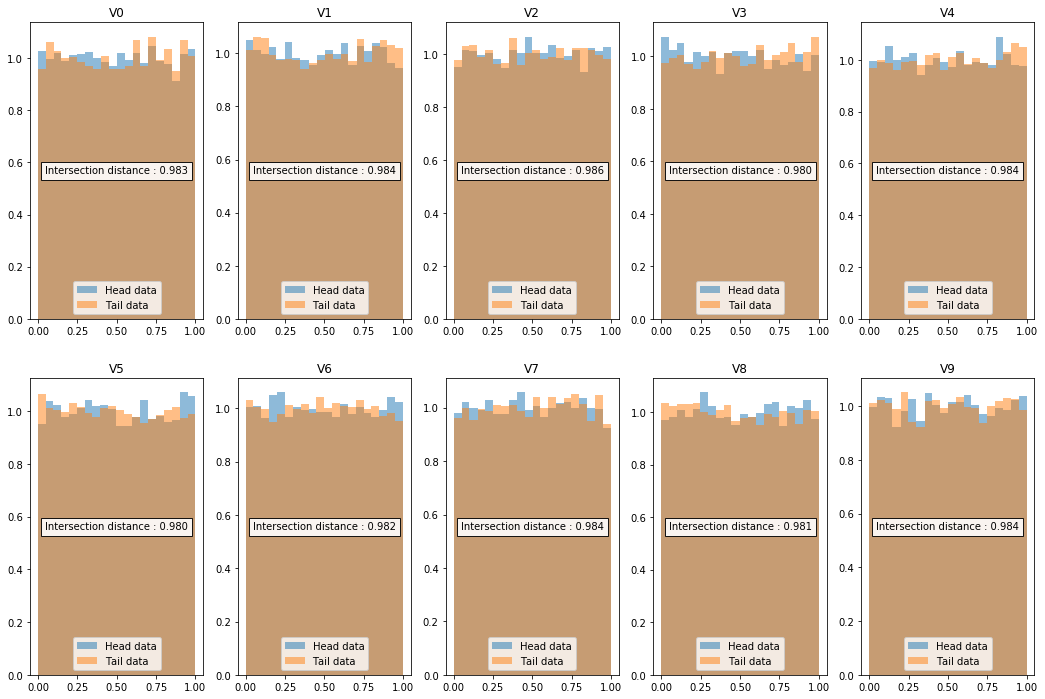

In [27]:
fig = plt.figure(figsize=(18,12))
intersections = []
for i in range(10):
    intersections.append(variable_drift(x_1.loc[:,i], x_2.loc[:,i], 20, f'V{str(i)}', subplot=(2, 5, i+1)))
plt.show(block=True)

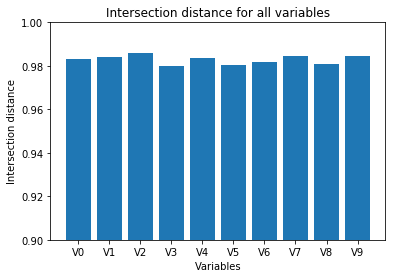

In [28]:
plt.bar([f"V{c}" for c in x_1.columns], intersections)
plt.ylim((0.9, 1))
plt.title('Intersection distance for all variables')
plt.xlabel('Variables')
plt.ylabel('Intersection distance')
plt.show()

W przypadku wartości pojedynczych zmiennych dryft nie jest widoczny. Nie oznacza to jednak, że faktycznie dryft nie występuje.

### Intersection distance dla reszt z obu modeli.

**Intersection distance dla reszt predykcji obu modeli na danych testowych odpowiednich dla każdego modelu**

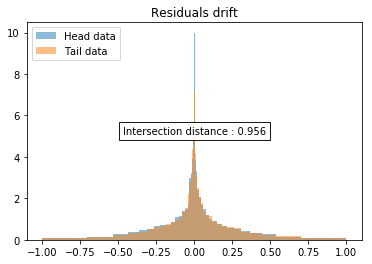

In [29]:
_ = variable_drift(pd.Series(y_1_test - lr_model_1.predict_proba(x_1_test)[:, 1]), 
               pd.Series(y_2_test - lr_model_2.predict_proba(x_2_test)[:, 1]), 40, "Residuals drift", legend_loc="upper left")

Oba modele poradzily sobie bardzo podobnie w predykcji zbioru który następuje blisko zbioru treningowego i w którym nie nastąpil jeszcze istotny dryft. Oznacza to, że trudność predykcji jest podobna na calym zbiorze.

**Intersection distance dla reszt predykcji pierwszego modelu dla danych testowych z początku zbioru oraz końca zbioru**

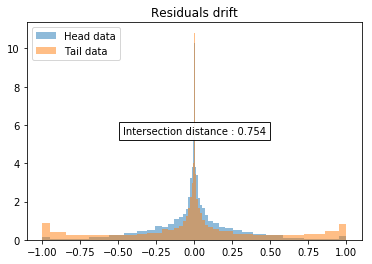

In [30]:
_ = variable_drift(pd.Series(y_1_test - lr_model_1.predict_proba(x_1_test)[:, 1]), 
               pd.Series(y_2_test - lr_model_1.predict_proba(x_2_test)[:, 1]), 40, "Residuals drift", legend_loc="upper left")

W tym wypadku widać, że pierwszy model radzil sobie istotnie gorzej na danych z końca zbioru danych. Oznacza to, że zjawisko dryftu występuje i w przypadku budowania systemu predykcyjnego, należy podjąć dzialania w celu minimalizacji tego zjawiska.

### Pole pomiędzy krzywymi PDP dla obu modeli.

In [31]:
def prep_points(model, X, col, no_points):
    x = pd.concat([X] * no_points)
    x[col] = np.repeat(np.linspace(X[col].min(), X[col].max(), no_points), X.shape[0])
    x['preds'] = model.predict_proba(x)[:,1]
    x = x.groupby(col).agg({'preds':'mean'}).reset_index()
    return x

def pdp_diff(model1, model2, x_head, x_tail, no_points = 100):
    fig, ax_tuple = plt.subplots(2, 5, sharey=True, figsize=(18,12))
    for feature_index, col in enumerate(x_head.columns):
        x_1 = prep_points(model1, x_head, col, no_points)
        x_2 = prep_points(model2, x_tail, col, no_points)
        ax = ax_tuple[feature_index // 5, feature_index % 5]
        ax.plot(x_1[col], x_1['preds'], label='head data', color = 'green')
        ax.plot(x_2[col], x_2['preds'], label='tail data', color='black')
        ax.fill_between(x_1[col], x_1['preds'], x_2['preds'], where=x_2['preds'] >= x_1['preds'], facecolor='green', alpha=0.3, interpolate=True)
        ax.fill_between(x_1[col], x_1['preds'], x_2['preds'], where=x_2['preds'] < x_1['preds'], facecolor='red', alpha=0.3, interpolate=True)
        area = (x_1['preds'] - x_2['preds']).abs().iloc[1:] @ np.diff(x_1[col])
        ax.text(x=0, y=0.1, s=f'Area between curves: {area:.4f}')
        ax.set_title(f'Variable {feature_index}')
        ax.legend()

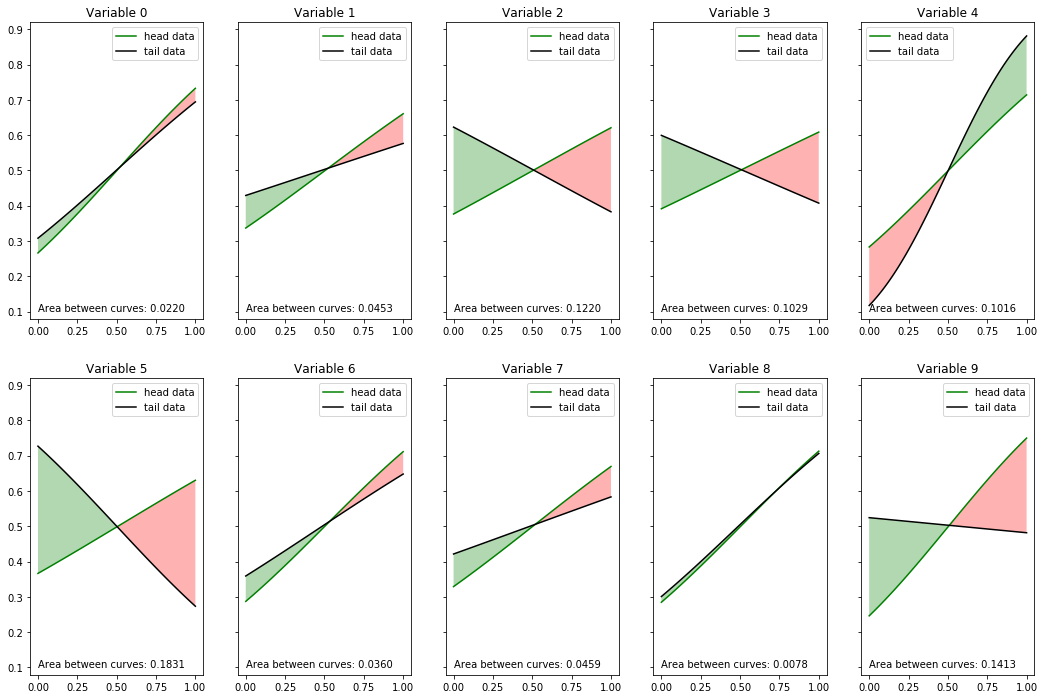

In [32]:
pdp_diff(lr_model_1, lr_model_2, x_1, x_2, no_points = 100)

Jak widać na powyższych wykresach zmiana odpowiedzi modelu występuje i w przypadku niektórych zmiennych jest bardzo duża. Szczególnie widać to w przypadku zmiennych 2, 3, 5 i 9.
Jest to potwierdzenie wcześniejszego przypuszczenia, że dryft rzeczywiście istnieje.

## Podsumowanie

W analizowanym przypadku wystąpil istotny dryft przez co model wyuczony na początkowych danych tracil dokladność wraz z uplywem czasu.
W takim przypadku należy rozważyć na przyklad:
* trenowanie nowego modelu co określony czas
* dotrenowywanie modelu na nowych danych (np. w przypadku sieci neuronowych)
* zwiększyć wagę przypadków nowszych podczas uczenia modelu (najlepiej polaczyć z innymi metodami)
* zrozumieć w jakim kierunku zachodzą zmiany i stworzyć dodatkowy model, który nanosi poprawki standardowe predykcje
* przygotować dane tak aby minimalizować efekt dryftu np. dla predykcji ceny akcji przewidywać zmianę ceny zamiast jej konkretną wartość 